First check that you have pytorch installed, instructions are here: https://pytorch.org/get-started/locally/ , prefferably do it with anaconda if you can, I think that will lead to less problems down the road if we use other libraries.

If cuda toolkit isnt available and you have an nvidia gpu try to get that too (it might be contained within anaconda pytorch package): https://docs.nvidia.com/cuda/cuda-installation-guide-microsoft-windows/index.html

Also note that because the dataset is large I added it to the .gitignore, you should download it from here : https://www.kaggle.com/c/cassava-leaf-disease-classification/data, and extract it into the data/ folder of the project


In [1]:
import sys
print(sys.version)

3.8.5 (default, Sep  3 2020, 21:29:08) [MSC v.1916 64 bit (AMD64)]


In [2]:
import torch
import os 
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as img
import torchvision
import pandas as pd
import skorch
import pickle

from torch import FloatTensor, LongTensor, nn, optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchvision import transforms, datasets, models

from sklearn.experimental import enable_halving_search_cv # noqa this is a new recently added feature im trying out
from sklearn.model_selection import train_test_split,GridSearchCV,HalvingGridSearchCV
from sklearn.metrics import accuracy_score, f1_score

from skorch import NeuralNetClassifier
from skorch.dataset import CVSplit
from skorch.helper import SliceDataset

from pathlib import Path
from IPython.core.debugger import set_trace
%matplotlib inline

use_cuda = True
if not torch.cuda.is_available() or not use_cuda:
    print("if you have an nvidia gpu get the cuda core package")
    device = torch.device('cpu')
else:
    print("cuda is available")
    # torch.cuda.set_device(0) # possible fix to illegal memory access error
    device = torch.device('cuda:0')

cuda is available


Splitting data into train and test sets and loading the validation set

In [3]:
#setting the path to the directory containing the pics
path = './data/train_images'
test_path = './data/test_images'

labelled_dataset = pd.read_csv(r'./data/train.csv')
submission = pd.read_csv(r'./data/sample_submission.csv')

with open('./data/label_num_to_disease_map.json') as f:
    mapping_dict = json.load(f)
print(mapping_dict)

#labelled_dataset = labelled_dataset.head(250) # tiny dataset for fast debugging, comment when training for real

# Parameters
train, test = train_test_split(labelled_dataset, test_size=0.25, random_state=7, stratify=labelled_dataset.label)
# split made with random state 7 and 0.25 stratified test size was originally used for training and testing on CV and on the main loop,
# so the models that I have saved used this split

train, validation = train_test_split(train, test_size=0.25, random_state=7, stratify=train.label) # further split the training set into validation

should_match_index = 6
print(labelled_dataset.values[should_match_index])

{'0': 'Cassava Bacterial Blight (CBB)', '1': 'Cassava Brown Streak Disease (CBSD)', '2': 'Cassava Green Mottle (CGM)', '3': 'Cassava Mosaic Disease (CMD)', '4': 'Healthy'}
['1000910826.jpg' 2]


In [4]:
from collections import Counter

Counter(labelled_dataset.label) # counts the elements' frequency

Counter({0: 1087, 3: 13158, 1: 2189, 2: 2386, 4: 2577})

In [5]:
print("Majority classifier accuracy: {}".format(13158/(1087+13158+2189+2386+2577)))

Majority classifier accuracy: 0.6149460204701593


Majority classifier (so our baseline) has an accuracy of 61.49%


Label Cassava Bacterial Blight (CBB) appears 1087 times<br>
Label Cassava Brown Streak Disease (CBSD) appears 2189 times<br>
Label Cassava Green Mottle (CGM) appears 2386 times<br>
Label Cassava Mosaic Disease (CMD) appears 13158 times<br>
Label Healthy appears 2577 times<br>
Because the labels arent equally represented the dataset split is stratified so each split has an equal amount of a certain label
<br><br>
Create custom dataset class for the images, and a transform to be applied to these images as part of preprocessing for learning <br>
All pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224. The images have to be loaded in to a range of [0, 1] and then normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225].


In [6]:
class CassavaDataset(Dataset):
    def __init__(self, data, path , transform = None):
        super().__init__()
        self.data = data.values
        self.path = path
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self,index):
        img_name,label = self.data[index]
        img_path = os.path.join(self.path, img_name)
        image = img.imread(img_path)
        if self.transform is not None:
            image = self.transform(image)
        return image, label

# original resolution is 800 x 600
# Parameters
cassava_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((600,600)),
    transforms.RandomHorizontalFlip(),
    #transforms.RandomRotation(180),
    transforms.RandomResizedCrop(340), # minimum is 299 for inceptionv3 224. Bigger image = more vram usage
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    # (the means and standard deviations of each of the 3 image channels)
])

cassava_test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((600,600)),
    #transforms.CenterCrop(340), 
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    # (the means and standard deviations of each of the 3 image channels)
])

train_dataset = CassavaDataset(train, path, cassava_transform )
test_dataset = CassavaDataset(test, path, cassava_test_transform)
valid_dataset = CassavaDataset(validation, path, cassava_test_transform)
#valid_dataset = CassavaDataset(submission, test_path, cassava_test_transform)

print(len(train_dataset))
print(len(test_dataset))
print(len(valid_dataset))
print(len(labelled_dataset))

12035
5350
4012
21397


In [7]:
print(train_dataset[0]) # how a transformed image tensor looks like, its label is 2
print(train_dataset[0][0].size())
print(test_dataset[0][0].size())

(tensor([[[ 0.1426,  0.1597,  0.1597,  ...,  0.4337,  0.4851,  0.5193],
         [ 0.1426,  0.1426,  0.1426,  ...,  0.4679,  0.5193,  0.5536],
         [ 0.1426,  0.1597,  0.1597,  ...,  0.5193,  0.5536,  0.5878],
         ...,
         [-0.5082, -0.4911, -0.4911,  ...,  1.9578,  1.8893,  1.7865],
         [-0.5253, -0.5082, -0.5082,  ...,  2.1290,  2.0777,  2.0092],
         [-0.5424, -0.5253, -0.5253,  ...,  2.2318,  2.2147,  2.1804]],

        [[ 0.8704,  0.8880,  0.9055,  ...,  1.0630,  1.0630,  1.0630],
         [ 0.8880,  0.8880,  0.8880,  ...,  1.0805,  1.0805,  1.0805],
         [ 0.8880,  0.8880,  0.9055,  ...,  1.0980,  1.0980,  1.0980],
         ...,
         [ 0.3627,  0.3803,  0.3803,  ...,  1.2731,  1.1856,  1.0805],
         [ 0.3627,  0.3803,  0.3803,  ...,  1.6057,  1.5182,  1.4132],
         [ 0.3627,  0.3803,  0.3978,  ...,  1.8158,  1.7458,  1.6758]],

        [[ 0.7925,  0.7751,  0.7576,  ...,  1.2805,  1.2805,  1.2631],
         [ 0.7751,  0.7402,  0.7228,  ...,  

In [8]:
# Parameters
n_epochs = 80 # on final training this should be high (around 30 for my desktop pc)
num_classes = 5 # 5 labels
batch_size = 32 # minimum batch size for inception v3 is 2, 20 to 32 seems to be fine for me (no cuda vram errors)
test_batch_size = 10 # higher image resolution so bigger size
early_stopping_threshold = 7 # this many epochs of no improvement stops trainining
params_dict_main = {
    "vgg": {
        "lr": 0.0003, #0.0005 or 0.001
        "wd": 0.001, #0.001 or 0.0025 used for CV
        "batch": 20,
        "spe": len(train_dataset)/20,
    },
    "google_net": {
        "lr": 0.0003, # 0.001 or 0.0003
        "wd": 0.001, #0.001 or 0.01
        "batch": 32,
        "spe": len(train_dataset)/32,
    },
    "resnet": {
        "lr": 0.0003, # 0.001 or 0.0003
        "wd": 0.001, #0.001 or 0.01
        "batch": 32,
        "spe": len(train_dataset)/32,
    },
    "alexnet": {
        "lr": 0.0003, # 0.001 or 0.0003
        "wd": 0.001,
        "batch": 32,
        "spe": len(train_dataset)/32,
    }
}

# pin memory should be enabled if you use cuda cores to speed up transfer between cpu and gpu,
# drop last is there if the last batch contains 1 sample for inception v3 (if its not enabled for inception theres an error)
# num workers is 0 unless you're using linux or mac os x, because paralelization in windows is broken
# using Adam optimizer, the max batch size for me is around 28, after that it uses too much vram (i have 8gb)



# using SGD optimizer, i can use up to 32
# using different pre processing params, i could get bigger batch sizes since the images would be smaller

Show an image from the dataset

Correct class: Cassava Green Mottle (CGM)
Filename: 1000910826.jpg


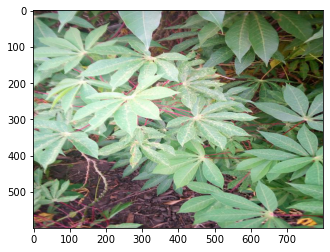

In [24]:
def show_image(index, image_dataset=labelled_dataset):  
    plt.imshow(img.imread('{}/{}'.format(path,image_dataset.values[index][0]))) # set the correct resolution here
    print('Correct class: {}'.format(mapping_dict[str(image_dataset.values[index][1])]))
    print('Filename: {}'.format(image_dataset.values[index][0]))
    
show_image(6)

Using resnet 18 pretrained pytorch model

In [10]:
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__) 
# Use this number below as the torchvision version for the alternative resnet model or else theres a version conflict

PyTorch Version:  1.7.1
Torchvision Version:  0.8.2


Model selection below, choices are "resnet", "alexnet", "vgg", "google_net"

In [11]:
def get_model(model_string):
    if model_string == "google_net":
        net = models.inception_v3(pretrained=True,aux_logits=False) # googlenet is based on inception v1, this is improved
        net = net.cuda() if use_cuda else net
        num_ftrs = net.fc.in_features
        net.fc = nn.Linear(num_ftrs, num_classes)

    if model_string == "vgg":
        net = models.vgg16(pretrained=True)
        net = net.cuda() if use_cuda else net
        net.fc = nn.Linear(4096, num_classes)

    if model_string == "alexnet":
        net = models.alexnet(pretrained=True)
        net = net.cuda() if use_cuda else net  
        net.fc = nn.Linear(4096, num_classes)

    if model_string == "resnet":
        net = models.resnet18(pretrained=True)
        net = net.cuda() if use_cuda else net
        num_ftrs = net.fc.in_features
        net.fc = nn.Linear(num_ftrs, num_classes)
        
    net.fc = net.fc.cuda() if use_cuda else net.fc    
    return net

# RUN THIS if models are already saved
def get_saved_model(model_name, model_type="TRAIN", skorch_wrap=False): # model type is either "CV" or "TRAIN" depending on how it was trained
    if model_type == "CV": # this return skorch NeuralNetClassifier object unless skorch wrap is true
        with open(r"./cross_validation/models/{}_best_model_{}.pickle".format(model_name,model_type), "rb") as input_file:
            e = pickle.load(input_file)
        if not skorch_wrap:
            e = e.module_
        return e
    elif model_type == "TRAIN": # this returns torch model
        e = torch.load("./cross_validation/models/{}_best_model_{}.pt".format(model_name,model_type))
        if skorch_wrap:
            e = NeuralNetClassifier(
                e,
                max_epochs=5,
                optimizer=torch.optim.SGD,
                criterion=nn.CrossEntropyLoss,
                device=device,
            )
            e.initialize()
        return e
    
def accuracy(out, labels):
    _,pred = torch.max(out, dim=1)
    return torch.sum(pred==labels).item()

The block belos should be used as the main function for training our model AFTER we found the best features using the cross validation method with parameter search.<br>The original base code for the block above this text and 2 blocks below was found at the following link, but it was heavily modified for our dataset and to work with our 4 different models not just resnet: https://www.pluralsight.com/guides/introduction-to-resnet (i think its basic pytorch boilerplate code)<br> <br> What I did with the models is called feature extraction, the models were all pretrained on imagenet: <br>

In feature extraction, we start with a pretrained model and only update the final layer weights from which we derive predictions. It is called feature extraction because we use the pretrained CNN as a fixed feature-extractor, and only change the output layer.

In [12]:
# Will plot the accuracy of the models below and save them to a file
def plot_model_acc(model_name, save_only=True):
    fig = plt.figure(figsize=(20,10))
    plt.title("Train-Validation Accuracy for {}".format(model_name))
    plt.plot(train_acc, label='train')
    plt.plot(val_acc, label='validation')
    plt.xlabel('num_epochs', fontsize=12)
    plt.ylabel('accuracy', fontsize=12)
    plt.legend(loc='best')
    if save_only:
        plt.savefig('./plots/{}_lr{}_bs{}.png'.format(model_name,str(params_dict_main[model_name]["lr"]).replace(".","dot"),params_dict_main[model_name]["batch"]), bbox_inches='tight')
        plt.clf()
        plt.close('all')

In [13]:
#from optimizers import DemonRanger # uncomment if using alternative optimizers
import adabound
# this should be used after finding good starting parameters with the cross validation parameter tuning below
# Parameters
skip_this = True # find good starting parameters first, using cv, then set this to false
model_index = 0 # set model index to use here

# commented models are considered done from my part
string_array = ["vgg"] #["google_net","resnet","alexnet","vgg"]

torch.backends.cudnn.benchmark = True # speeds up training by some variable amount
first_run = True
while(True and not skip_this):
    if(len(string_array) > 0):
        if not first_run:
            torch.cuda.empty_cache()
            model_name = string_array.pop(0)
            net = get_saved_model(model_name,"TRAIN") 
            #net = get_model(model_name)
        else:
            model_name = string_array[model_index]
            net = get_saved_model(model_name,"TRAIN")
            #net = get_model(model_name)
            string_array.remove(model_name)
            first_run = False

        # Parameters (train set, validation set, test set)
        train_dataloader = DataLoader(dataset = train_dataset,batch_size = params_dict_main[model_name]["batch"],shuffle=True,num_workers=0,pin_memory=True,drop_last=True)
        valid_dataloader = DataLoader(dataset = valid_dataset,batch_size = test_batch_size,shuffle=False,num_workers=0,pin_memory=True,drop_last=True)
        criterion = nn.CrossEntropyLoss() # used this since we have 5 mutually exclusive classes
        ''' # other options for optimizers after SGD
        optimizer = DemonRanger(params=net.parameters(),
                                lr=params_dict_main[model_name]["lr"],
                                weight_decay=params_dict_main[model_name]["wd"],
                                epochs = n_epochs,
                                step_per_epoch = params_dict_main[model_name]["spe"], 
                                betas=(0.9,0.999,0.999), # restore default AdamW betas
                                nus=(1.0,1.0), # disables QHMomentum
                                k=0,  # disables lookahead
                                alpha=1.0, 
                                IA=False, # enables Iterate Averaging
                                rectify=False, # disables RAdam Recitification
                                AdaMod=False, #disables AdaMod
                                AdaMod_bias_correct=False, #disables AdaMod bias corretion (not used originally)
                                use_demon=True, #enables Decaying Momentum (DEMON)
                                use_gc=False, #disables gradient centralization
                                amsgrad=False # disables amsgrad
                                )
        optimizer = adabound.AdaBound(net.parameters(), lr=params_dict_main[model_name]["lr"], final_lr=0.1)
        ''' 

        optimizer = optim.SGD(net.parameters(),  # the same optimizer that was used for CV
            lr=params_dict_main[model_name]["lr"],
            weight_decay=params_dict_main[model_name]["wd"],
            momentum=0.9
        )
        improvement_patience = 0
    else:
        break
    print("-------------------------------------------------------------------")
    print("Using model: {}".format(model_name))
    print_every = int(len(train_dataloader)*0.1) # print upon completion of every 10% of the dataset
    if print_every == 0: print_every = 1
    
    model_best_valid_loss = Path('./cross_validation/models/{}_best_model_TRAIN_best_loss.pt'.format(model_name))
    if model_best_valid_loss.is_file(): # use saved best validation loss instead
        valid_loss_min = torch.load('./cross_validation/models/{}_best_model_TRAIN_best_loss.pt'.format(model_name))
    else:
        valid_loss_min = np.Inf
    print("initial loss: {}".format(valid_loss_min))
    
    val_loss = []
    val_acc = []
    train_loss = []
    train_acc = []
    total_step = len(train_dataloader)
    for epoch in range(1, n_epochs+1):
        running_loss = 0.0
        correct = 0
        total=0
        print(f'Epoch {epoch}\n')
        for batch_idx, (data_, target_) in enumerate(train_dataloader):
            data_, target_ = data_.to(device), target_.to(device)
            optimizer.zero_grad()

            outputs = net(data_)
            loss = criterion(outputs, target_)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _,pred = torch.max(outputs, dim=1)

            #set_trace() # Debugger entrypoint for inspecting predictions

            correct += torch.sum(pred==target_).item()
            total += target_.size(0)
            if (batch_idx) % print_every == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                       .format(epoch, n_epochs, batch_idx, total_step, loss.item()))
        train_acc.append(100 * correct / total)
        train_loss.append(running_loss/total_step)
        print(f'\ntrain-loss: {np.mean(train_loss):.4f}, train-acc: {(100 * correct/total):.4f}')
        batch_loss = 0
        total_t=0
        correct_t=0
        with torch.no_grad():
            net.eval()
            for data_t, target_t in (valid_dataloader):
                data_t, target_t = data_t.to(device), target_t.to(device)
                outputs_t = net(data_t)
                loss_t = criterion(outputs_t, target_t)
                batch_loss += loss_t.item()
                _,pred_t = torch.max(outputs_t, dim=1)
                correct_t += torch.sum(pred_t==target_t).item()
                total_t += target_t.size(0)
            val_acc.append(100 * correct_t/total_t)
            val_loss.append(batch_loss/len(valid_dataloader))
            network_learned = batch_loss < valid_loss_min
            print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * correct_t/total_t):.4f}\n')

            #Print and save graph
            plot_model_acc(model_name)
            
            if network_learned:
                valid_loss_min = batch_loss
                torch.save(valid_loss_min, './cross_validation/models/{}_best_model_TRAIN_best_loss.pt'.format(model_name))
                torch.save(net, './cross_validation/models/{}_best_model_TRAIN.pt'.format(model_name))
                improvement_patience = 0
                print('Improvement-Detected, save-model')
            else:
                improvement_patience += 1
        if improvement_patience > early_stopping_threshold:
            break
        net.train()

Time can vary alot depending on your set parameters, cpu, gpu, whether you're using cuda etc. <br>

Now instead of rewriting the above boilerplate pytorch code for training and evaluating the model, ill do cross validation using the skorch library, which basically allows you to abstract away the unnecesarry code, do cross validation and hyper parameter tuning with grid search cv <br>

Cross validation is done on the training set only, so 75% of the total, this set is then split into k folds (in our case 3) then the model is trained on k-1 folds and evaluated on the remaining 1 fold, after the cross validation, i evaluate the models on the before unseen test set (25% of total)

In [14]:
import gc
print("Skorch Version: ",skorch.__version__)
gc.collect()
torch.cuda.empty_cache()

Skorch Version:  0.9.0


In [15]:

# because of vram, test this on your pc and try to use a range from 32 to 64
vgg_batch = 17
google_net_batch = 32
resnet_batch = 32
alexnet_batch = 32

params_dict = { # possible parameter combinations to evaluate 
    "vgg": {
        'lr': [0.0001,0.0005], # best so far 0.0005 83% 0.0003 82 % 0.00003  76 % (4)
        'optimizer__weight_decay': [0.0025,0.04], # best so far 0.0025, then  0.01 , then 0.0001
        'optimizer__momentum': [0.9], # for sgd only 
        'batch_size': [vgg_batch],
    },
    "google_net": {
        'lr': [0.001,0.01], # best so far 0.001 83.5%,  0.003 83 %, 2nd 0.03 78% (4)
        'optimizer__weight_decay': [0.01,0.001], # best so far 0.001, then 0.001
        'optimizer__momentum': [0.9], # for sgd only
        'batch_size': [google_net_batch],
    },
    "resnet": {
        'lr': [0.001,0.008],  # best so far 0.001 84%, 0.003 82%, 0.0003 78% (4)
        'optimizer__weight_decay': [0.01,0.001], # best so far 0.001 then 0 and 0.001
        'optimizer__momentum': [0.9], # for sgd only 
        'batch_size': [resnet_batch],
    },
    "alexnet": {
        'lr': [0.001,0.008],# best so far 0.001 76%,  0.0003 73% 0.00003  70 % (4)
        'optimizer__weight_decay': [0.01,0.001], # best 0.01, za 0.00003 vsi podobni (0,0.1,0.001)
        'optimizer__momentum': [0.9], # for sgd only
        'batch_size': [alexnet_batch],
    }
}
best_estimators = []

In [16]:
string_array = ["vgg","google_net","resnet","alexnet"] # also the order

skip_this = True # set this to true after finding good starting parameters here

best_params_models = []
# the code below basically compares the model tuned with the parameters above to find the best performing one, we then use
# the bigger native pytorch code chunk above to actually train a model with the best found params and evaluate it
first_run = True
y_train = np.array(train.label)
if not skip_this:
    while(True):
        if(len(string_array)>0):
            model_name = string_array.pop(0)
            net = get_model(model_name)
            gc.collect()
            torch.cuda.empty_cache()
            torch.backends.cudnn.benchmark = True # speeds up training by some variable amount
            first_run = False
        else:
            del gs
            gc.collect()
            torch.cuda.empty_cache()
            break
        print("---------------------")
        print("---------------------")
        print("Now cross validating {}------------------------------------------".format(model_name))
        print("---------------------")
        print("---------------------")
        skorch_classifier = NeuralNetClassifier(
            net,
            max_epochs=5,
            optimizer=torch.optim.SGD,
            criterion=nn.CrossEntropyLoss,
            device=device,
        )
        gs = HalvingGridSearchCV(skorch_classifier, # or GridSearchCV 
                          param_grid=params_dict[model_name], 
                          scoring='accuracy',
                          refit='accuracy', # competition entries will be evaluated bassed on classification accuracy
                          verbose=3, # outputs info
                          cv=3, # because the percentages of labels across folds are close to equal (stratified), and label 1
                         )      # only occurs 1000 times, 3 folds appears to be the maximum, with 333 cases of label 1 per fold
        train_sliceable = SliceDataset(train_dataset)
        gs.fit(train_sliceable, y_train)
        best_params_models.append(gs.best_params_)
        best_estimators.append(gs.best_estimator_) # saves the model
        with open('./cross_validation/models/{}_best_model_CV.pickle'.format(model_name), 'wb') as handle:
            pickle.dump(gs.best_estimator_, handle, protocol=pickle.HIGHEST_PROTOCOL)
        with open('./cross_validation/best_params_{}.json'.format(model_name), 'w') as jsonfile: # Save best params for each model
            json.dump(gs.best_params_, jsonfile)

    print(best_params_models) # order = ["vgg","google_net","resnet","alexnet"]
    with open('./cross_validation/best_params.json', 'w') as jsonfile: # Save best params for each model
        json.dump(best_params_models, jsonfile)  

In [17]:
# here load all the best models and evaluate each on the test set 
# since they are too big to predict all at once (32 gb ram, 8 gb vram) , i load them in batches

test_batch = 15
y_test = np.array(test.label)
string_array = ["google_net","resnet","alexnet","vgg"]  # ["google_net","resnet","alexnet","vgg"]

model_pred_dict = {
    "google_net": [],
    "resnet": [],
    "alexnet": [],
    "vgg": []
}
for model_name in string_array:
    model = get_saved_model(model_name,"TRAIN",skorch_wrap=True)
    y_predictions = []
    for i in range(0,len(test_dataset),test_batch):
        if len(test_dataset) == i:
                break
        temp_list = []
        for n in range(i,i+test_batch):
            if len(test_dataset) == n:
                break
            temp_list.append(test_dataset[n][0])
        if i%(test_batch*100) == 0: print("{} out of {} done".format(i,len(test_dataset)))
        temp_list = torch.stack(temp_list)
        y_predictions.append(model.predict(temp_list))
    y_predictions = [item for sublist in y_predictions for item in sublist]
    model_pred_dict[model_name] = y_predictions
    print("!!!! Model {} Accuracy on test set: {}, f1macro-score: {}".format(model_name,accuracy_score(y_test,y_predictions),f1_score(y_test,y_predictions,average='macro')))

0 out of 5350 done
1500 out of 5350 done
3000 out of 5350 done
4500 out of 5350 done
!!!! Model google_net Accuracy on test set: 0.8758878504672897, f1macro-score: 0.7603116853352395
0 out of 5350 done
1500 out of 5350 done
3000 out of 5350 done
4500 out of 5350 done
!!!! Model resnet Accuracy on test set: 0.8766355140186916, f1macro-score: 0.7635279360352605
0 out of 5350 done
1500 out of 5350 done
3000 out of 5350 done
4500 out of 5350 done
!!!! Model alexnet Accuracy on test set: 0.8607476635514019, f1macro-score: 0.7365217693813411
0 out of 5350 done
1500 out of 5350 done
3000 out of 5350 done
4500 out of 5350 done
!!!! Model vgg Accuracy on test set: 0.8482242990654205, f1macro-score: 0.6662177508002923


In [18]:
wrong_google = np.equal(model_pred_dict["google_net"],y_test)
wrong_alex = np.equal(model_pred_dict["alexnet"],y_test)
wrong_vgg = np.equal(model_pred_dict["resnet"],y_test)
wrong_resnet = np.equal(model_pred_dict["vgg"],y_test)
count = 0
wrong_google_count = 0
wrong_alex_count = 0
wrong_vgg_count = 0
wrong_resnet_count = 0

for index,value in enumerate(y_test):
    if wrong_google[index] == False and wrong_alex[index] == False and wrong_vgg[index] == False and wrong_resnet[index] == False:
        count += 1
    if wrong_google[index] == False:
        wrong_google_count += 1
    if wrong_alex[index] == False:
        wrong_alex_count += 1
    if wrong_vgg[index] == False:
        wrong_vgg_count += 1
    if wrong_resnet[index] == False:
        wrong_resnet_count += 1
print("Number of samples that every one of the models got wrong: {}".format(count))
print("Number of samples that google net got wrong: {}".format(wrong_google_count))
print("Number of samples that alexnet got wrong: {}".format(wrong_alex_count))
print("Number of samples that vgg got wrong: {}".format(wrong_vgg_count))
print("Number of samples that resnet got wrong: {}".format(wrong_resnet_count))

Number of samples that every one of the models got wrong: 359
Number of samples that google net got wrong: 664
Number of samples that alexnet got wrong: 745
Number of samples that vgg got wrong: 660
Number of samples that resnet got wrong: 812


Correct class: Cassava Bacterial Blight (CBB)
Filename: 1784661840.jpg
Predicted: Cassava Green Mottle (CGM)


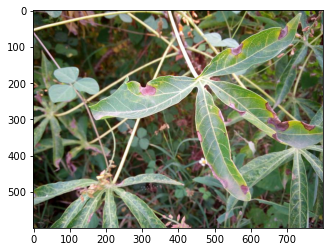

In [25]:
model_name = "google_net"
missclassification_index = 30 # Show the N-th incorrect image prediction


mask_of_predictions = model_pred_dict[model_name] == y_test
incorrect_indices = [i for i, e in enumerate(list(mask_of_predictions)) if e == False]
show_image(incorrect_indices[missclassification_index],test) 
print("Predicted: {}".format(mapping_dict[str(model_pred_dict[model_name][incorrect_indices[missclassification_index]])]))